# Imputing Fraud Values and Segmenting Merchants
This notebook imputes the fraud values for both merchants and consumers, and does preliminary segmentation of merchants.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
import sklearn
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [2]:
spark = (
    SparkSession.builder.appName('Fraud Imputation')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '9g')
    .config('spark.executor.memory', '6g')
    .getOrCreate()
)

24/10/16 19:42:24 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 192.168.0.52 instead (on interface en0)
24/10/16 19:42:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/16 19:42:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/16 19:42:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/16 19:42:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
transactions = spark.read.parquet(".././data/curated/transaction_external")
transactions.show()

24/10/16 19:42:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+------+-----------------+--------------------+--------------------+----+---------+--------------------------+----------+--------------+----------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|gender|fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|    SHAPE_Leng|      SHAPE_Area|               lon|                lat

In [4]:
transactions.printSchema()

root
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- type: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- AREASQKM21: double (nullable = true)
 |-- SHAPE_Leng: double (nullable = true)
 |-- SHAPE_Area: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- Median_age_persons: double (nullable = 

# Merchant Fraud Imputation Model
A KNN model is used to impute the fraud values for both merchants and consumers, using the tags of the merchant, the state of the consumer, the dollar value of the transaction, and the merchant's take rate.

The following cell demonstrates the model, and gives its root mean squared error.

RMSE: 3.6329403183729947


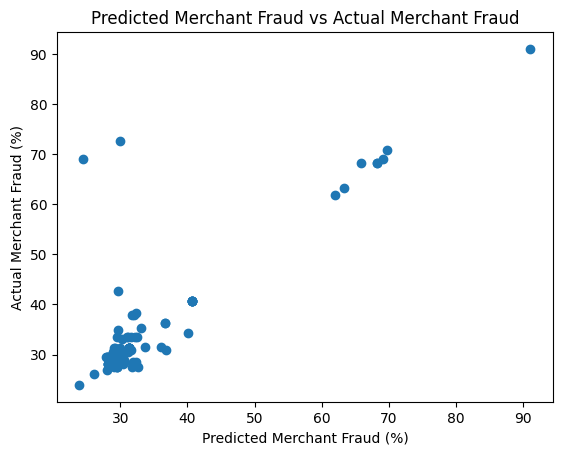

In [5]:
categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

X = transactions.drop('merchant_fraud_probability', axis=1)
y = transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test)
plt.title("Predicted Merchant Fraud vs Actual Merchant Fraud")
plt.ylabel('Actual Merchant Fraud (%)')
plt.xlabel("Predicted Merchant Fraud (%)")
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

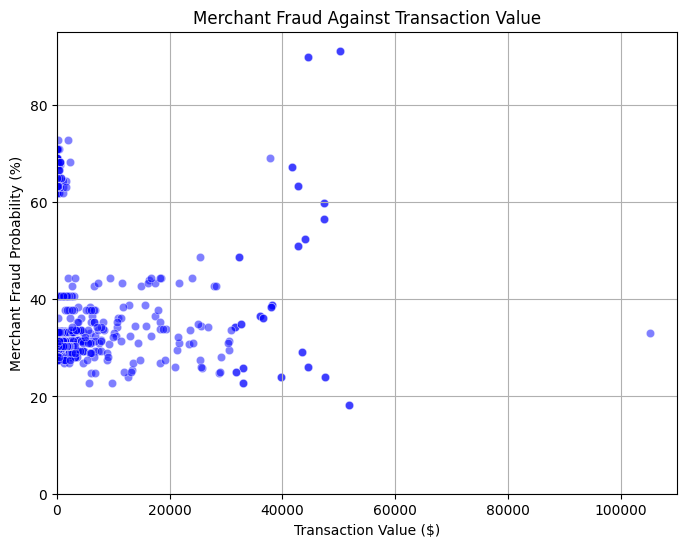

In [6]:
# Plot merchant fraud against transaction value
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(transactions, x='dollar_value', y='merchant_fraud_probability', alpha=0.5, color='blue')
plt.title("Merchant Fraud Against Transaction Value")
plt.ylabel('Merchant Fraud Probability (%)')
plt.xlabel("Transaction Value ($)")

plt.xlim((0, 110000))
plt.ylim((0, 95))
plt.grid()
plt.show()

## Impute fraud for all merchants using the full training set
This may take several minutes to run.

In [11]:
pipeline.fit(X, y)
transactions = pd.read_parquet(".././data/curated/transaction_external")

mask = transactions['merchant_fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('merchant_fraud_probability', axis=1)

transactions.loc[mask, 'merchant_fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions_merchant_imputed.parquet")

# Merchant Fraud Imputation Model

RMSE: 7.756431435879828


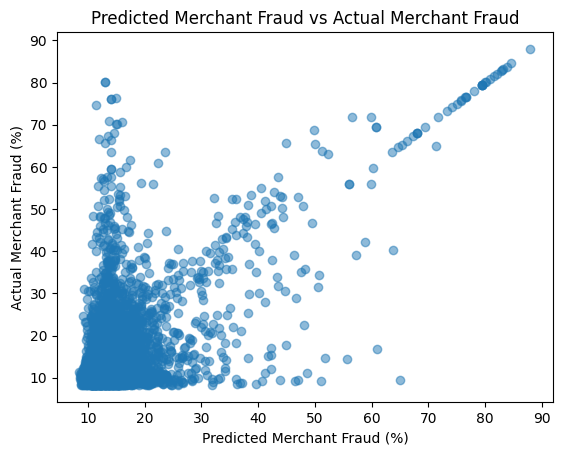

In [7]:
transactions = spark.read.parquet("../data/curated/transactions_merchant_imputed.parquet")

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=int(math.sqrt(len(transactions)) / 2), weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test, alpha=0.5)
plt.title("Predicted Merchant Fraud vs Actual Merchant Fraud")
plt.ylabel('Actual Merchant Fraud (%)')
plt.xlabel("Predicted Merchant Fraud (%)")
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

## Impute fraud for all consumers using the full training set
This may take several minutes to run.

In [ ]:
pipeline.fit(X, y)
transactions = spark.read.parquet("../data/curated/transactions_merchant_imputed.parquet")

mask = transactions['fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('fraud_probability', axis=1)

transactions.loc[mask, 'fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions_imputed.parquet")

# Preprocess the imputed values
The following cell creates the `expected_revenue` column, which is our key metric used for ranking, equal to `dollar value * (1 - merchant fraud probability) * (1 - consumer fraud probability) * take rate`.

Additionally, it adds the `is_holiday` feature, and the retail sales by state data.

In [14]:
# Add features to get transactions ready to pass to model
transactions = spark.read.parquet("../data/curated/transactions_imputed.parquet")
transactions = transactions.withColumn('expected_revenue', 
                                       transactions.dollar_value
                                       * (1.0 - transactions.merchant_fraud_probability / 100.0) 
                                       * (1.0 - transactions.fraud_probability / 100.0) 
                                       * transactions.take_rate / 100.0)
transactions = transactions.withColumn('day_of_week', F.dayofweek('order_datetime'))
transactions = transactions.withColumn('day_of_month', F.dayofmonth('order_datetime'))
transactions = transactions.withColumn('day_of_year', F.dayofyear('order_datetime'))
transactions = transactions.withColumn('month', F.month('order_datetime'))

transactions = transactions.withColumn(
    "is_holiday",
    F.when(F.col("order_datetime").isin([
        '2021-11-26',
        '2021-11-27',
        '2021-11-28',
        '2021-11-29',
        '2021-12-24',
        '2021-12-25',
        '2021-12-26',
    ]), F.lit(1)).otherwise(F.lit(0))
)

transactions = transactions.withColumn(
    "seasonal_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_seasonal"))
     .when(F.col("state") == "VIC", F.col("VIC_seasonal"))
     .when(F.col("state") == "QLD", F.col("QLD_seasonal"))
     .when(F.col("state") == "SA", F.col("SA_seasonal"))
     .when(F.col("state") == "WA", F.col("WA_seasonal"))
     .when(F.col("state") == "TAS", F.col("TAS_seasonal"))
     .when(F.col("state") == "NT", F.col("NT_seasonal"))
     .when(F.col("state") == "ACT", F.col("ACT_seasonal"))
     .otherwise(None)
)

transactions = transactions.withColumn(
    "original_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_original"))
     .when(F.col("state") == "VIC", F.col("VIC_original"))
     .when(F.col("state") == "QLD", F.col("QLD_original"))
     .when(F.col("state") == "SA", F.col("SA_original"))
     .when(F.col("state") == "WA", F.col("WA_original"))
     .when(F.col("state") == "TAS", F.col("TAS_original"))
     .when(F.col("state") == "NT", F.col("NT_original"))
     .when(F.col("state") == "ACT", F.col("ACT_original"))
     .otherwise(None)
)

transactions = transactions.withColumnRenamed("Total_seasonal", "total_seasonal_sales")
transactions = transactions.withColumnRenamed("Total_original", "total_original_sales")
transactions = transactions.select([col for col in transactions.columns if not col.endswith('original')])
transactions = transactions.select([col for col in transactions.columns if not col.endswith('seasonal')])

transactions.write.mode('overwrite').parquet("../data/curated/transactions_preprocessed.parquet")
transactions.show(truncate=False)

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+------------------+-------------------------------+-----+------+------------------+--------------------------------------+-----------------------------------------------------+----+---------+--------------------------+----------+---------------+----------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+--------------------+--------------------+--------------------+-----------+------------+-----------+----------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name     |address                        |state|gender|fraud_probability |merchant_name                         |tags                                                 |type|take_rat

# Merchant segmentation
We have segmented merchants by their average transaction value and their number of sales using a KMeans model, with K = 3.

As noted by (Ahmed, R., 2024), higher transaction values benefit more from onboarding to BNPL systems, so we would expect merchants in the high value, low sales segment to grow the greatest once onboarded.

These segments are investigated further in the `ranking.ipynb` notebook.

Ahmed, R. (2024, June 18). Testing the impact of buy now, pay later across 150,000+ checkout sessions. Stripe. https://stripe.com/blog/testing-the-impact-of-buy-now-pay-later

In [8]:
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

transactions = spark.read.parquet("../data/curated/transactions_preprocessed.parquet")

def skewness_udf(column):
    return (F.mean(column) - F.median(column)) / F.stddev(column)

window_spec = Window.partitionBy("merchant_abn").orderBy("order_datetime")

agg_df = transactions.groupBy("merchant_abn").agg(
    F.expr("percentile_approx(fraud_probability, 0.5)").alias("fraud_probability_median"),
    skewness_udf(F.col("fraud_probability")).alias("fraud_probability_skewness"),
    F.expr("percentile_approx(dollar_value, 0.5)").alias("dollar_value_median"),
    F.expr("percentile_approx(expected_revenue, 0.5)").alias("expected_revenue_median"),
    skewness_udf(F.col("dollar_value")).alias("dollar_value_skewness"),
    F.count("merchant_abn").alias("record_count"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("merchant_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
)

agg_df.show()

+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+------------------+
|merchant_abn|fraud_probability_median|fraud_probability_skewness|dollar_value_median|expected_revenue_median|dollar_value_skewness|record_count|                tags|take_rate|merchant_fraud_probability| mean_dollar_value|
+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+------------------+
| 10441711491|      13.981469844702758|       0.38977680993708913|  4184.883294138098|     146.31870423556205|   0.4506005262127406|           3|motor vehicle sup...|     5.77|        29.555244690425024| 5751.207887182689|
| 10487253336|      13.091596850582814|        0.2043608445425334| 359.87222862385426|      7.37545284454379

In [9]:
# Cluster using KMeans 
y = 'mean_dollar_value'
df = agg_df.toPandas()
df = df.fillna(0)

df['record_count'] = np.log10(df['record_count'])
df[y] = np.log10(df[y])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

df['cluster'] = pipeline.fit_predict(df[[
    'record_count', 
    y
]])

df.loc[df['cluster'] == 0, 'cluster'] = "Med price, Med sales"
df.loc[df['cluster'] == 1, 'cluster'] = "High price, Low sales"
df.loc[df['cluster'] == 2, 'cluster'] = "Low price, High sales"
clusters = spark.createDataFrame(df).select('merchant_abn', 'cluster')
clusters.write.mode('overwrite').parquet('../data/curated/clusters.parquet')
clusters.show()

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_26381/1917969549.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Med price, Med sales' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[df['cluster'] == 0, 'cluster'] = "Med price, Med sales"


+------------+--------------------+
|merchant_abn|             cluster|
+------------+--------------------+
| 10441711491|High price, Low s...|
| 10487253336|Low price, High s...|
| 10618089367|Low price, High s...|
| 10848766800|Low price, High s...|
| 11076688542|Med price, Med sales|
| 11199348915|Med price, Med sales|
| 11452293720|Low price, High s...|
| 11590404675|High price, Low s...|
| 11633090957|Med price, Med sales|
| 11766327188|Low price, High s...|
| 12103450178|High price, Low s...|
| 12171241826|Med price, Med sales|
| 12183270048|Low price, High s...|
| 12426913844|Low price, High s...|
| 12438697459|Low price, High s...|
| 12516851436|Med price, Med sales|
| 12578813079|Med price, Med sales|
| 13061606045|Med price, Med sales|
| 13093581573|Low price, High s...|
| 13159730941|Med price, Med sales|
+------------+--------------------+
only showing top 20 rows



/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_26381/3959689006.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(df, x='record_count', y=y, hue='cluster', palette=sns.color_palette(), alpha=0.5, s=30)


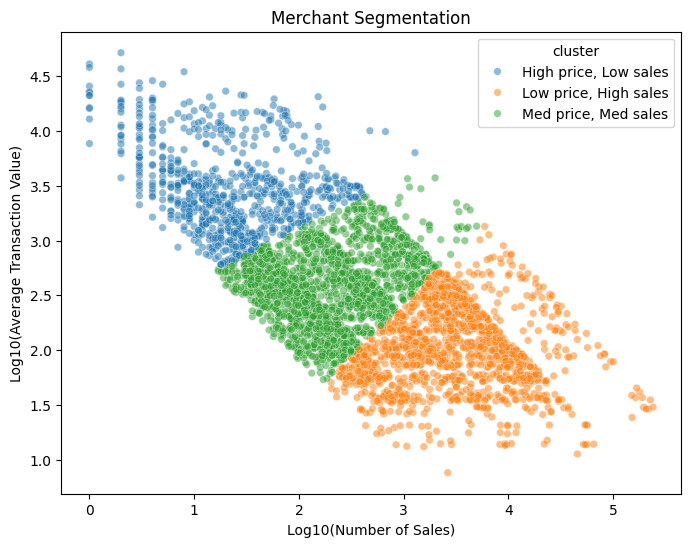

In [10]:
# Plot merchant segments
plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='record_count', y=y, hue='cluster', palette=sns.color_palette(), alpha=0.5, s=30)
plt.title("Merchant Segmentation")
plt.ylabel('Log10(Average Transaction Value)')
plt.xlabel("Log10(Number of Sales)")
plt.show()